In [1]:
import sys 
sys.path.append('../')
import copy

import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 8]

import TimeSeries.Preprocessing as pp


print("is GPU:",tf.test.is_gpu_available())
print("is cuda:",tf.test.is_built_with_cuda())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
is GPU: True
is cuda: True
2.10.0


In [2]:
#Load data

#Tranings daten
data_normal_train = pd.read_csv("Daten/Normal_12_03_24.csv")

#Test data
data_test_normal = pd.read_csv("Daten/Normal2.csv")
data_test_normal2 = pd.read_csv("Daten/Normal3.csv")

data_test_drehtisch_widerstand = pd.read_csv("Daten/Rondel_Widerstnd_12_03_24.csv")
data_test_widerstand_transportband = pd.read_csv("Daten/widerstand_Transport_12_03_24.csv")
data_test_widerstand_zufuerband = pd.read_csv("Daten/Zuführ_wiederstand_12_03_24.csv")




#all_test_data = [data_test_normal, data_test_zufürh_foerderband_widerstand]
all_test_data = [data_test_normal, data_test_normal2, data_test_drehtisch_widerstand, data_test_widerstand_transportband, data_test_widerstand_zufuerband]

all_test_data_names=["normal", "normal 2", "drehtisch widerstand",  "transport förderband widerstand", "zuführ förderband widerstand"]

In [3]:
data_normal_train.head()

,Timestamp,Drucksensor,Gesamtstrom,Ansteuerung Förderband,Ansteuerung Drehtisch,Ansteuerung Zuführförderband,Obere Position Greifer Erreicht,Untere Position Greifer Erreicht,Boolwert ob die Position des Separators für Flüssigkeiten geschlossen ist,Boolwert ob die Position des Separators für Feststoffen geschlossen ist,...,Integerwert für den Motorstrom am Zuführförderband,Integerwert für den Motorstrom am Drehtisch,Integerwert für die Raumtemperatur,Integerwert für die Temperatur am Motorgehäuse des Transportförderbands,Boolwert zur Ansteuerung des Flaschenfixierers,Boolwert zur Ansteuerung des der Greiferbacken,Boolwert zur Einleitung der Greifer-Verfahrbewegung nach unten,Boolwert zur Einleitung der Greiferdrehung auf 0°,Boolwert zur Einleitung der Greiferdrehung auf 270°,xN1_M0_SMU1_Buffer
0,0,639,12972,True,False,True,True,False,True,True,...,2156,0,5272,6614,False,False,False,True,False,NaN
1,6,639,12972,True,False,True,True,False,True,True,...,2156,0,5285,6668,False,False,False,True,False,NaN
2,13,637,12973,True,False,True,True,False,True,True,...,2156,0,5310,6645,False,False,False,True,False,NaN
3,19,637,12974,True,False,True,True,False,True,True,...,2156,1,5290,6657,False,False,False,True,False,NaN
4,25,637,12976,True,False,True,True,False,True,True,...,2156,1,5295,6657,False,False,False,True,False,NaN


In [4]:
used_variablen =  [0,1,2,12,13,14]          #list(np.arange(0,data_normal_train.shape[-1],1))        #[1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,]

ground_truth_variable=13
name_list = list(data_normal_train.columns.values.tolist())

name_dict = {} 
for i in range(len(name_list)):
    name_dict[i]=name_list[i]


In [5]:
print(name_dict)

{0: 'Timestamp', 1: 'Drucksensor', 2: 'Gesamtstrom', 3: 'Ansteuerung Förderband', 4: 'Ansteuerung Drehtisch', 5: 'Ansteuerung Zuführförderband', 6: 'Obere Position Greifer Erreicht', 7: 'Untere Position Greifer Erreicht', 8: 'Boolwert ob die Position des Separators für Flüssigkeiten geschlossen ist', 9: 'Boolwert ob die Position des Separators für Feststoffen geschlossen ist', 10: 'Boolwert zur Ansteuerung des Separators für Flüssigkeiten', 11: 'Boolwert zur Ansteuerung des Separators für Feststoffe', 12: 'Integerwert für den Motorstrom am Transportförderband', 13: 'Integerwert für den Motorstrom am Zuführförderband', 14: 'Integerwert für den Motorstrom am Drehtisch', 15: 'Integerwert für die Raumtemperatur', 16: 'Integerwert für die Temperatur am Motorgehäuse des Transportförderbands', 17: 'Boolwert zur Ansteuerung des Flaschenfixierers', 18: 'Boolwert zur Ansteuerung des der Greiferbacken', 19: 'Boolwert zur Einleitung der Greifer-Verfahrbewegung nach unten', 20: 'Boolwert zur Einlei

3
Timestamp

Train data


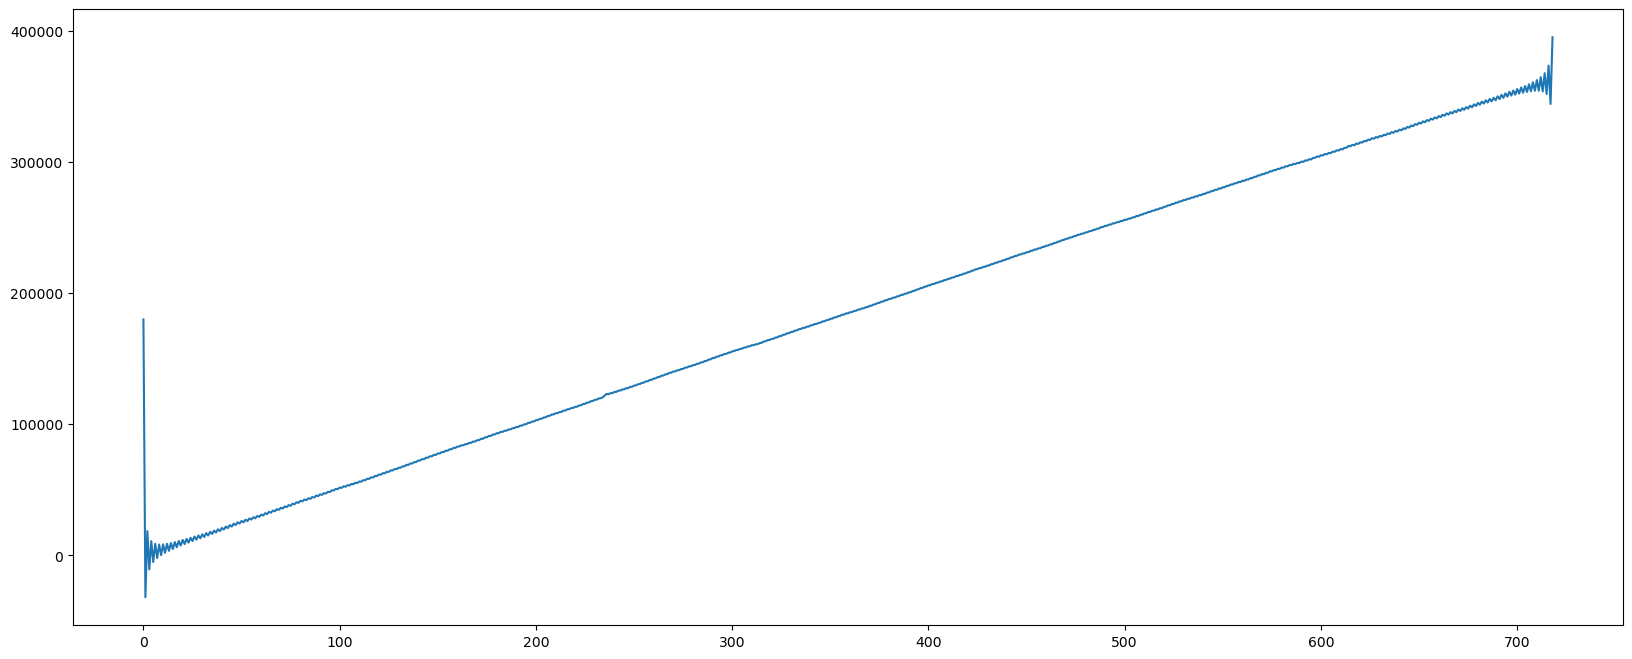

All test Data


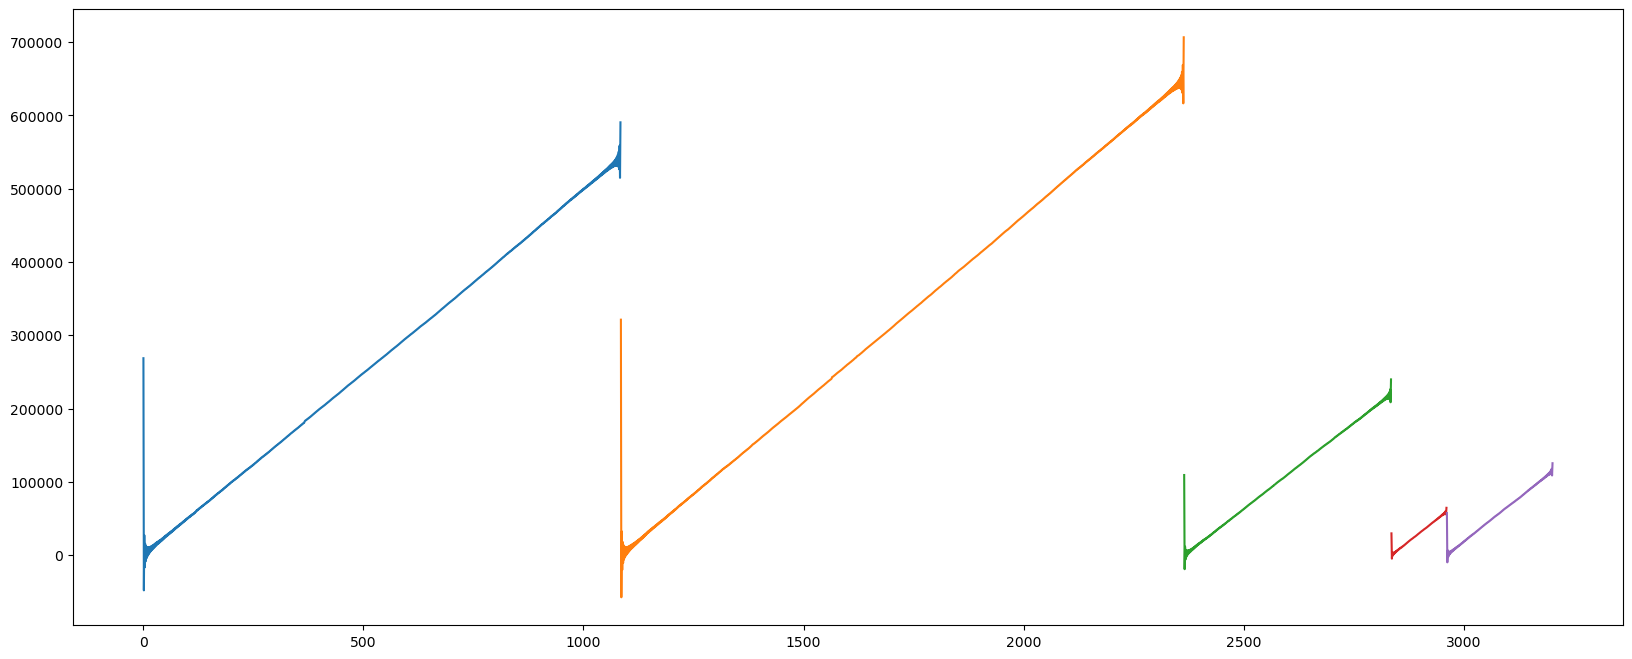

Drucksensor

Train data


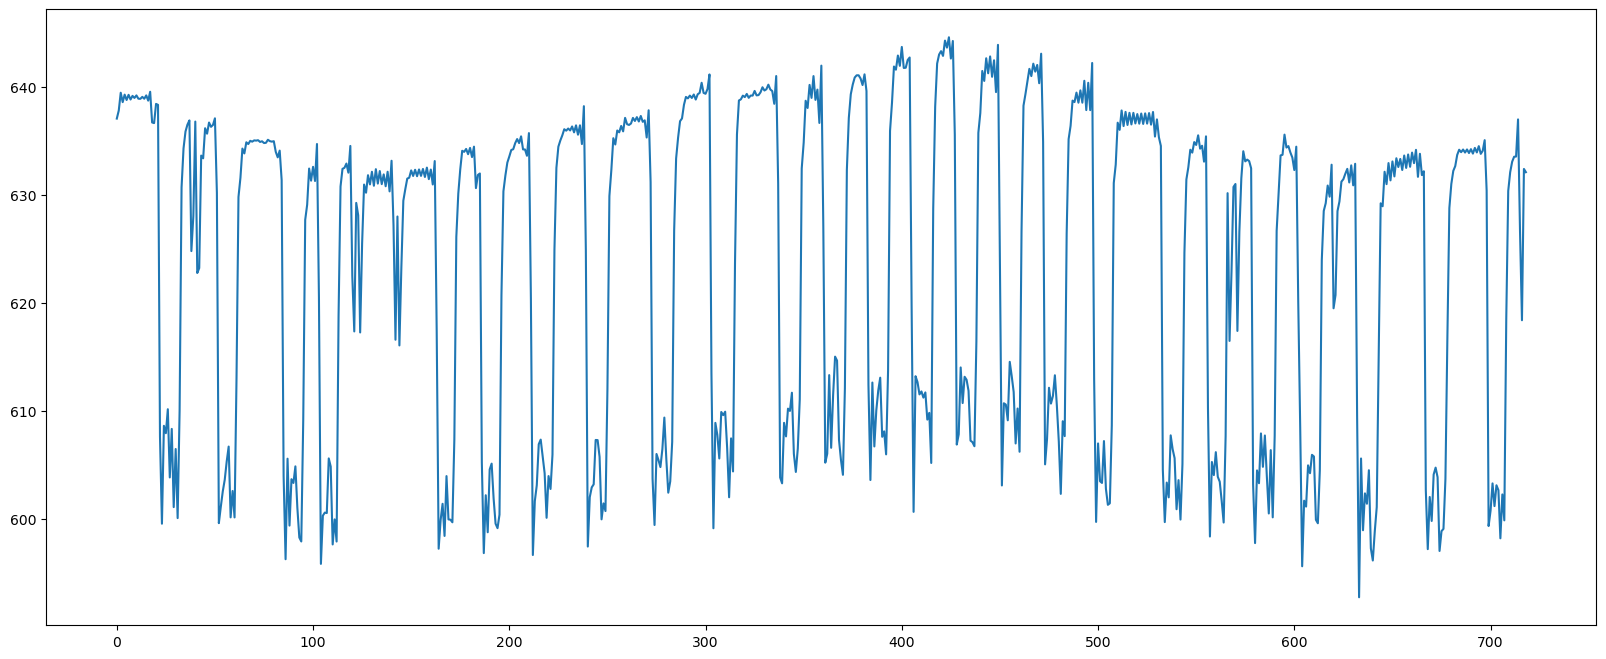

All test Data


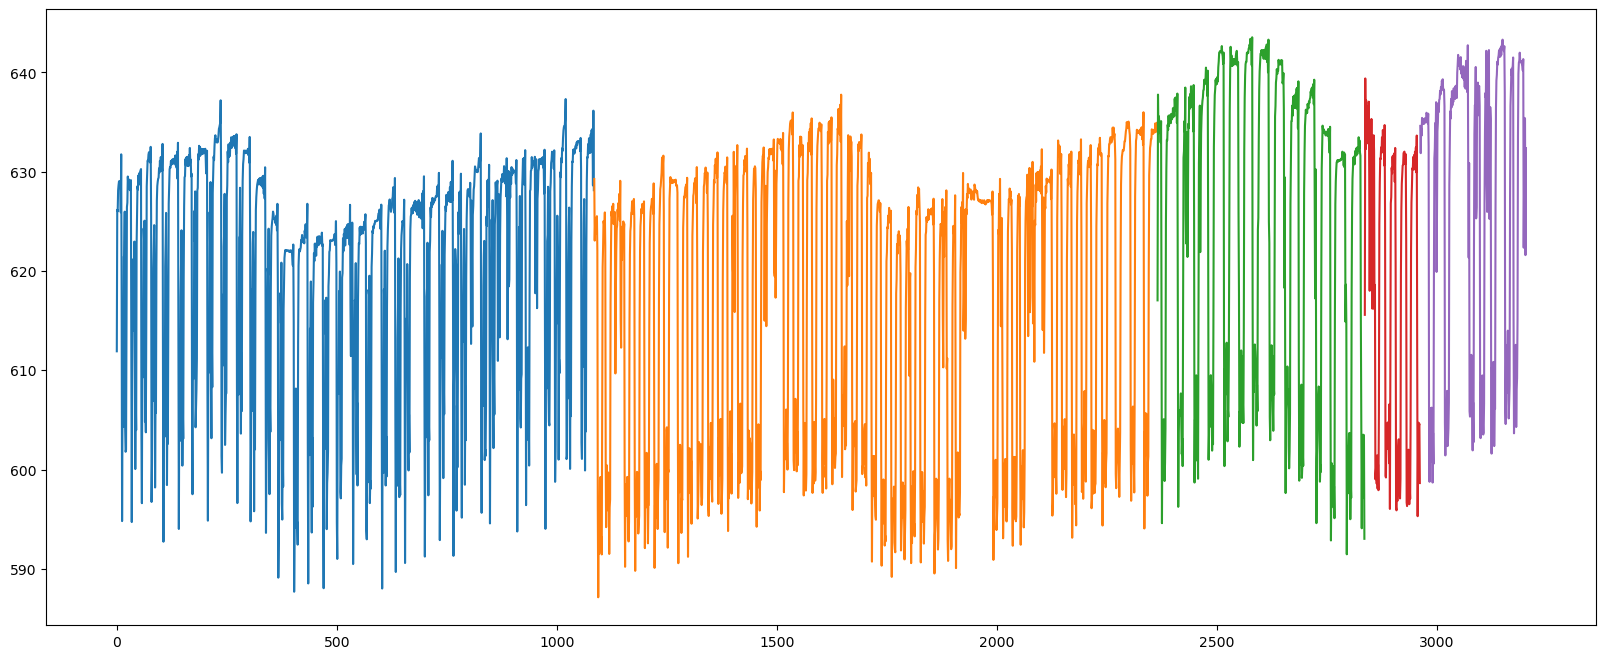

Gesamtstrom

Train data


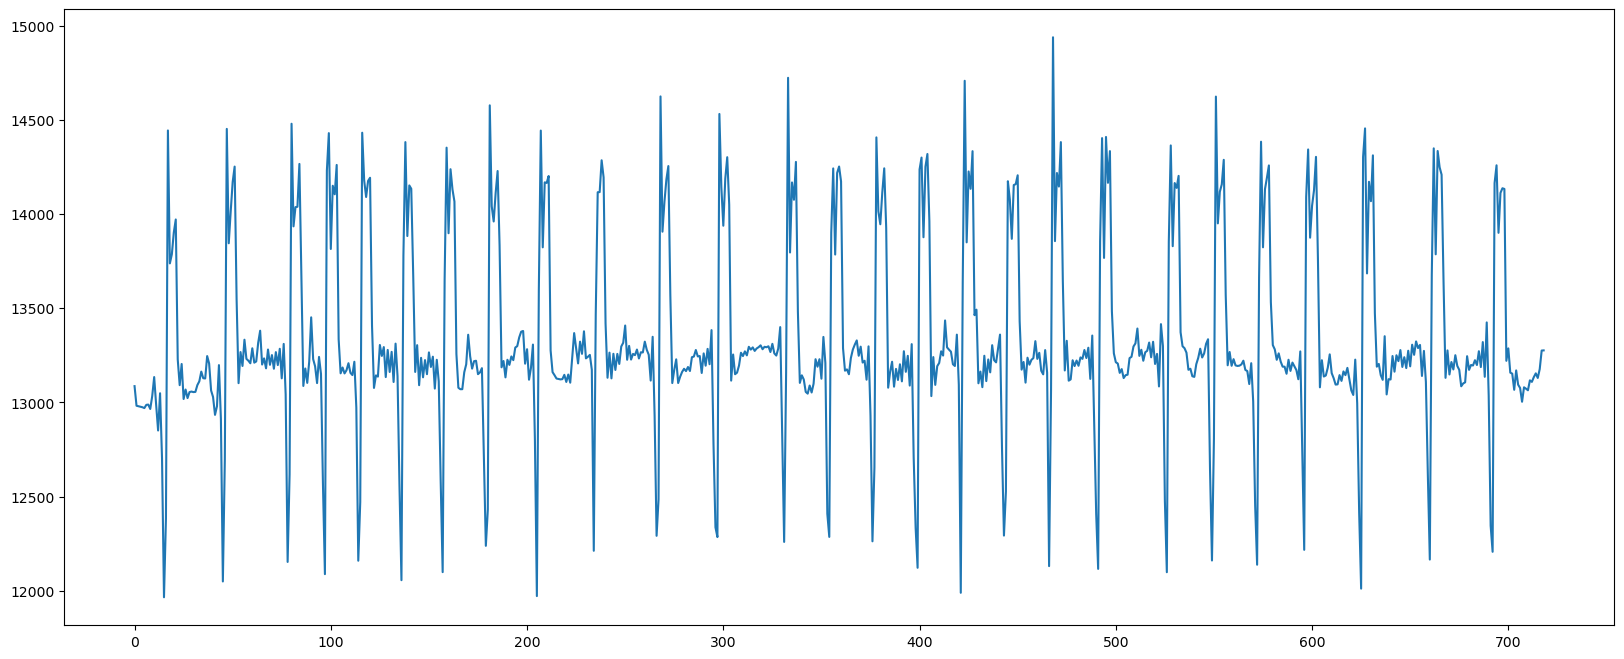

All test Data


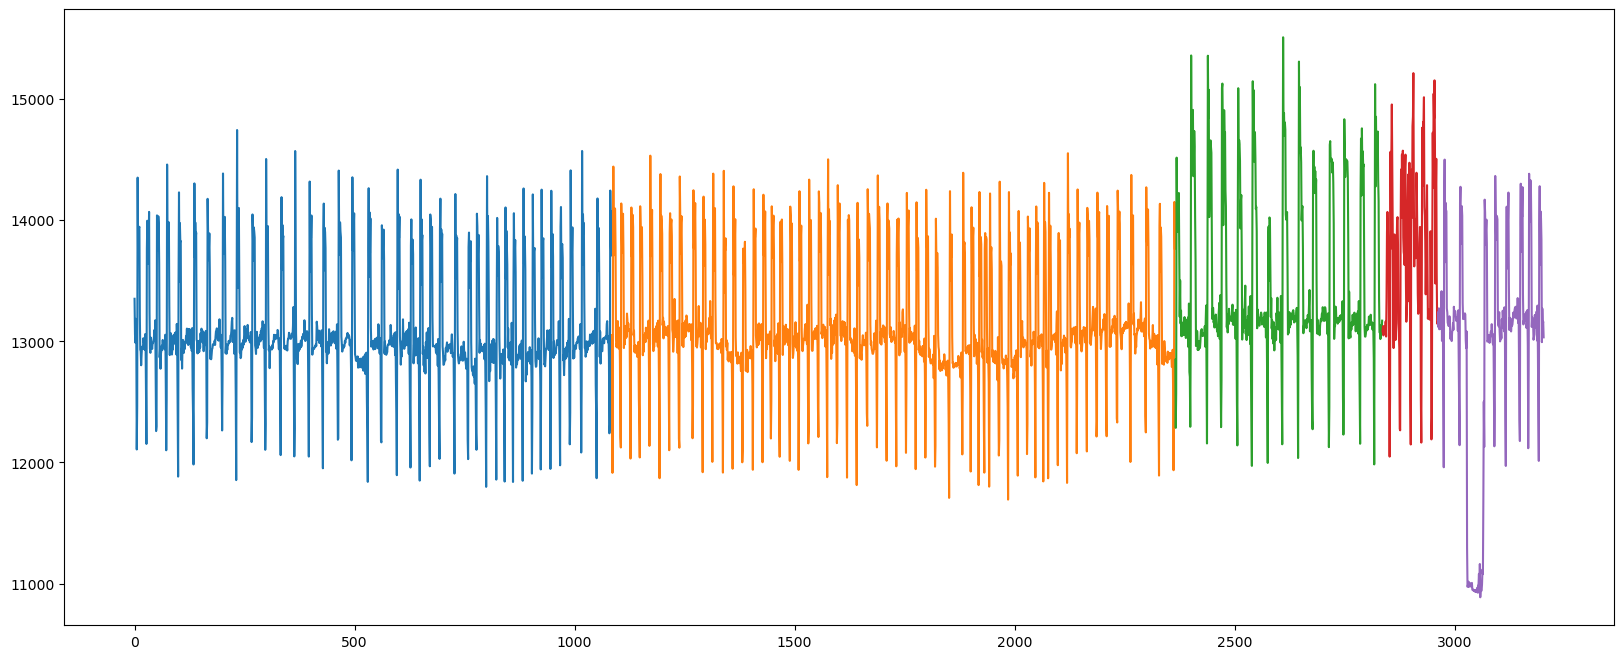

Integerwert für den Motorstrom am Transportförderband

Train data


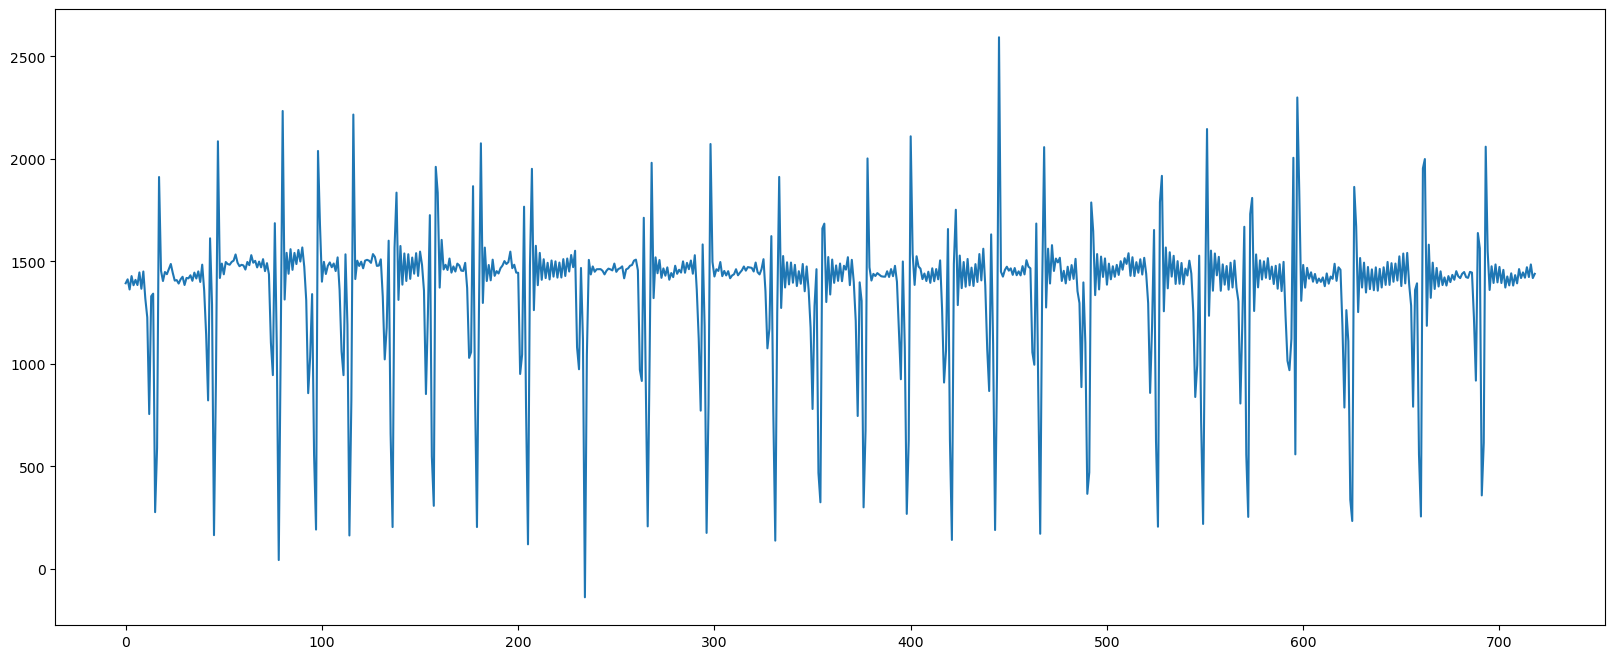

All test Data


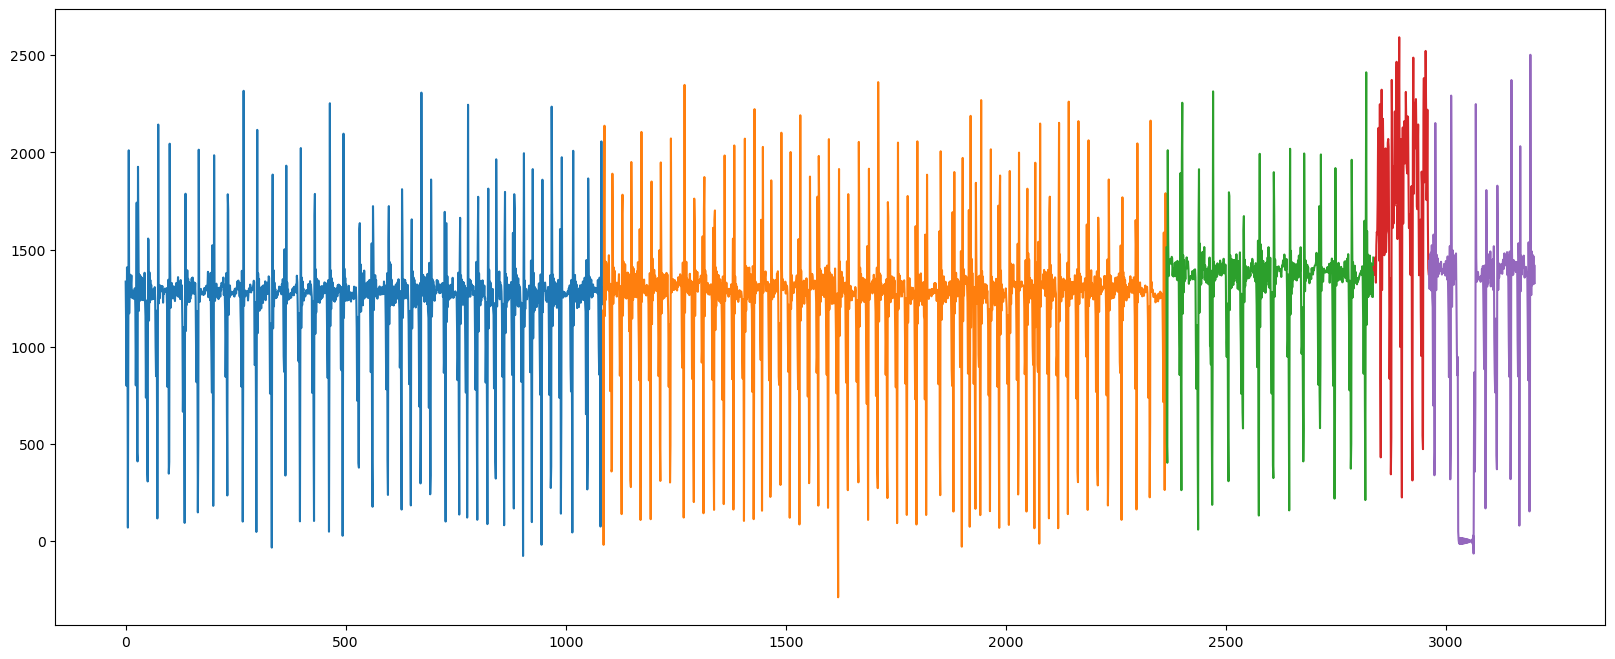

Integerwert für den Motorstrom am Zuführförderband

Train data


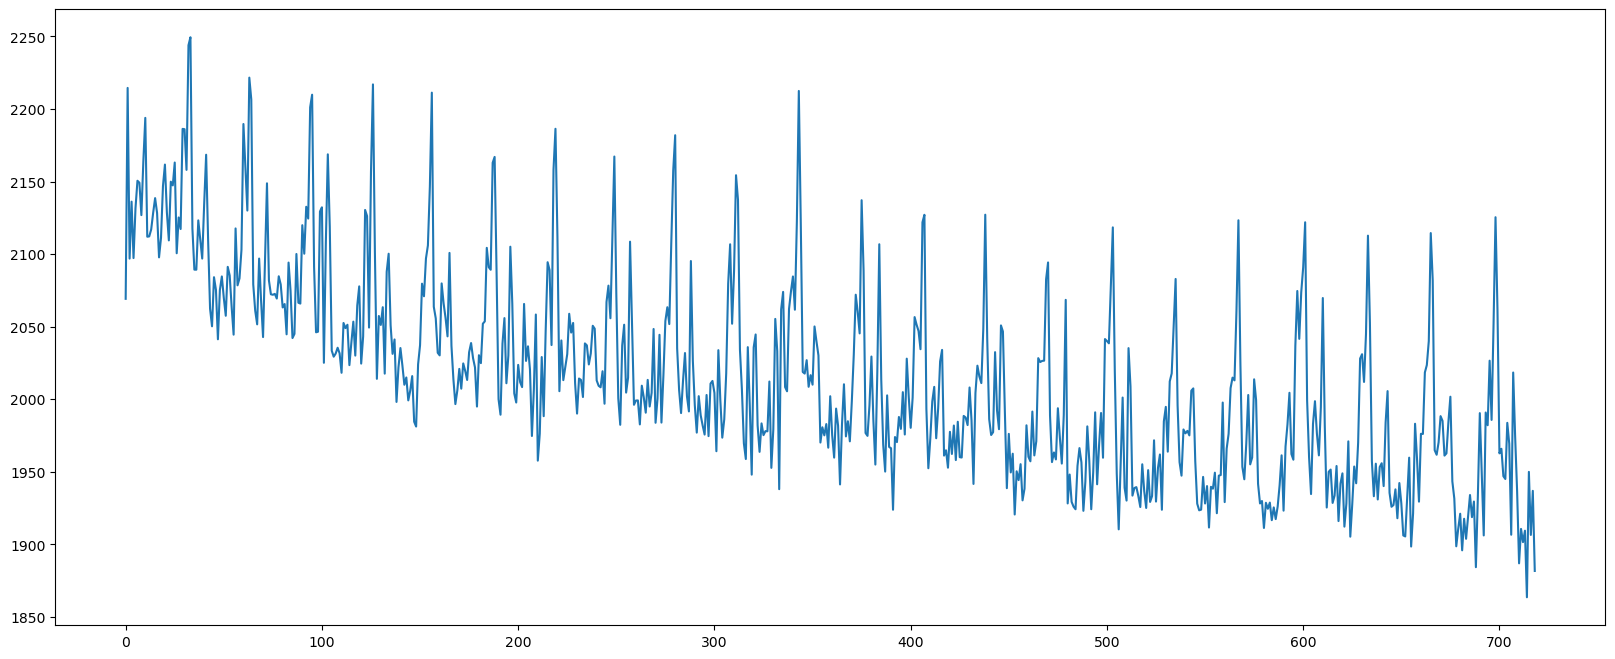

All test Data


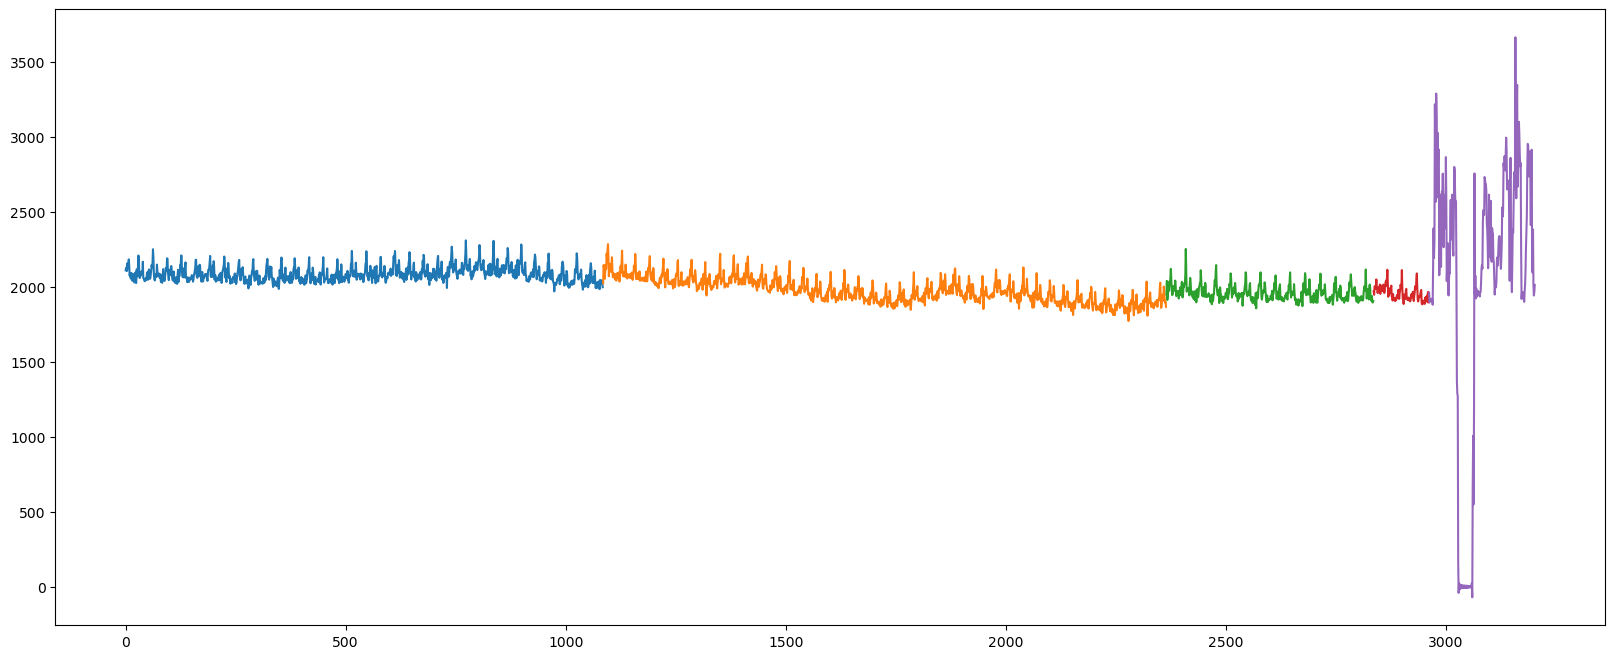

Integerwert für den Motorstrom am Drehtisch

Train data


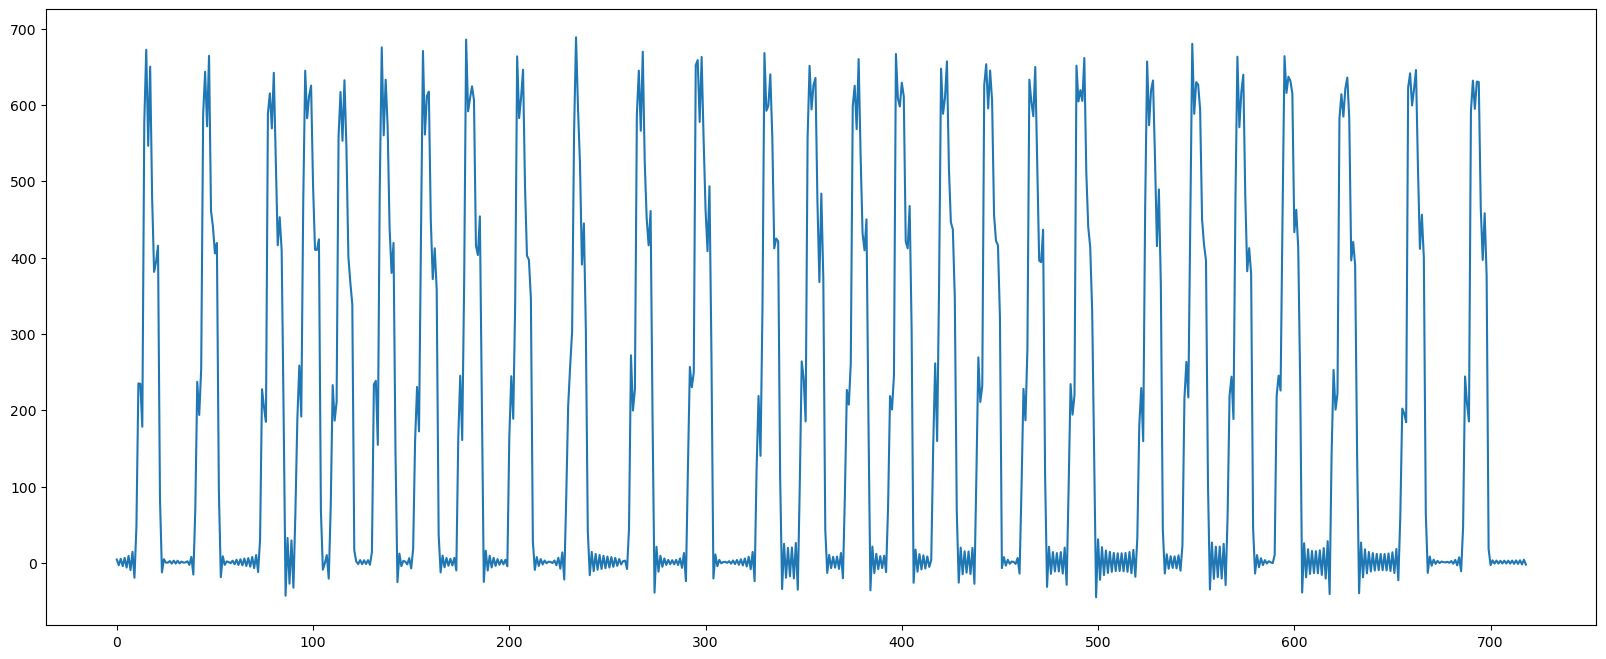

All test Data


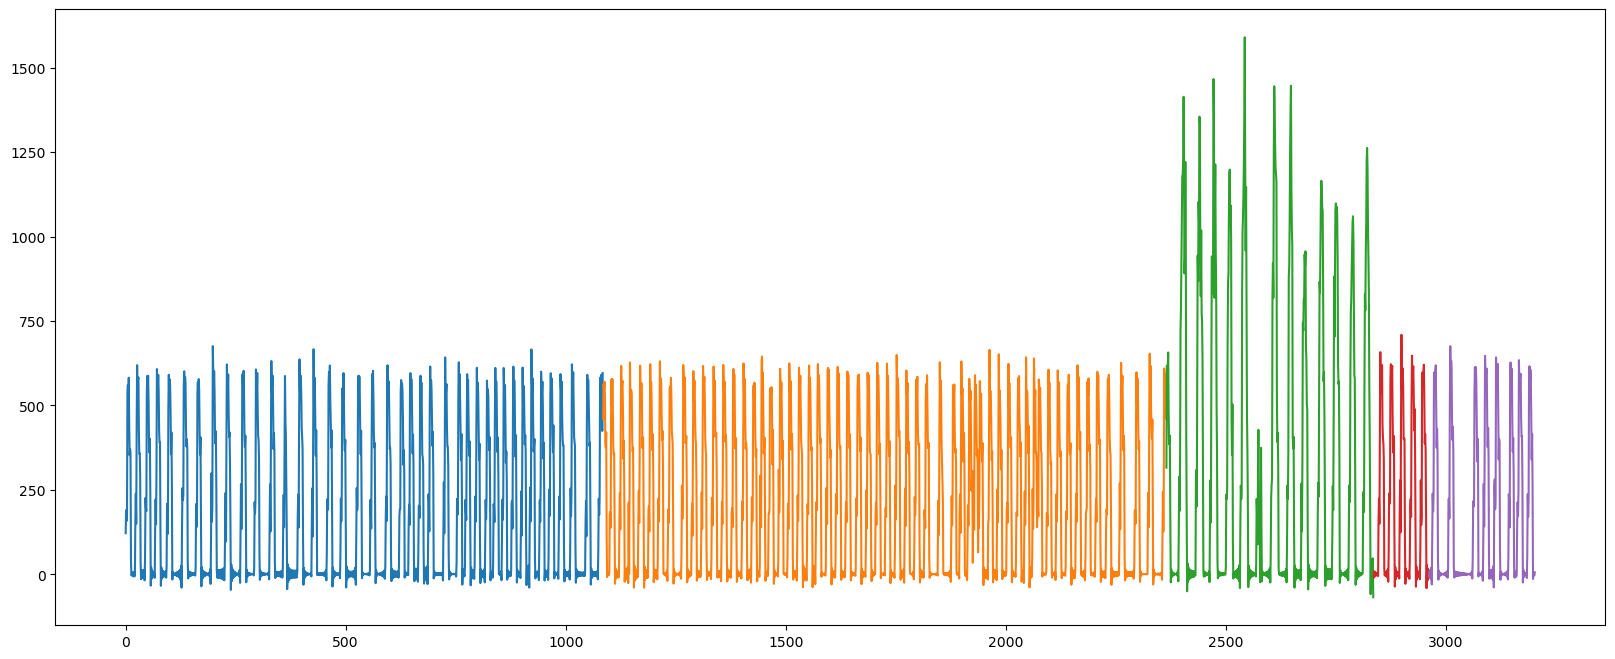

In [6]:
input_window=256
zoom=500
downsampling=100

var=used_variablen.index(12)
print(var)

for i in used_variablen:
    print(name_dict[i])

    print("\nTrain data")
    range=np.arange(0,len(pp.resample_timeseries(data_normal_train.iloc[:input_window*zoom,i], downsampling)))
    plt.plot(range,pp.resample_timeseries(data_normal_train.iloc[:input_window*zoom,i], downsampling))
    plt.show()
    count=0
    print("All test Data")
    for j, data in enumerate(all_test_data):
        #print(all_test_data_names[j])
        range=np.arange(count,count+len(pp.resample_timeseries(data.iloc[:input_window*zoom,i], downsampling)))
        count+=len(pp.resample_timeseries(data.iloc[:input_window*zoom,i], downsampling))
        plt.plot(range, pp.resample_timeseries(data.iloc[:input_window*zoom,i], downsampling))     


     
    plt.show()